In [249]:
import math
import numpy as np
import pandas as pd
import astropy.units as units
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import ks_2samp
from BASE9Analysis import readGaiaData
from BASE9Analysis import findSeparation

from matplotlib import font_manager
#point to font directory and find files within it
font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
#add fonts
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
# set font
plt.rcParams['font.family'] = 'Noto Sans JP'

%matplotlib inline

In [250]:
#read data from ecsv and round to 4 decimals
originalGaia=readGaiaData('M67data.ecsv')
originalGaia=originalGaia.round(4)

In [251]:
#create dataframe for photometry, and define analysis columns
ph = "/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.df"
phot = pd.read_csv(ph, sep=' ')

#0.02 CMprior w/o anything?
#0.25 CMprior and qMedian filters
#0.1 CMprior and qMedian filters

phot = phot[phot['CMprior'] >= 0.12]
#phot = phot[phot['G'] > 15]
#phot = phot[phot['G'] < 20]
#phot = phot[phot['sigG_BP'] < np.nanmedian(phot['sigG_BP'])]

#store any single star with a qMedian >= 0, and store any binary with qMedian >= 0.5
phot = phot[((phot['binary'] == False)) | ((phot['binary'] == True) & (phot['qMedian'] >= 0.5))]
#phot = phot[phot['sigG_BP'] < 0.0075]
#phot = phot[phot['qMedian'] >= 0.1]

# Calculations

In [252]:
nBinary = 0
nCluster = 0
count = 0
for i, row in phot.iterrows():
    if row['member']:
        nCluster += 1
        
    if row['binary']:
            nBinary += 1
            
    if row['qMedian'] <= 0.5:
            count += 1
            
print(f"# Binaries: {nBinary}")
print(f"# Cluster objects: {nCluster}")
print(f"Binary Fraction: {nBinary/nCluster:.4f}")
print(f"Std: {np.sqrt(nBinary)/nCluster:.3f}")
print(f"q>=0.5 Binaries: {count}")
print(f"q>=0.5 binary fraction: {count/nCluster:.4f}")
print(f"q>=0.5 std: {np.sqrt(count)/nCluster:.3f}")

# Binaries: 345
# Cluster objects: 1497
Binary Fraction: 0.2305
Std: 0.012
q>=0.5 Binaries: 1838
q>=0.5 binary fraction: 1.2278
q>=0.5 std: 0.029


In [253]:
# Load the data from file
res_data = np.loadtxt('/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.res', skiprows=1, usecols=[0, 1, 2, 3, 5])
age_all, metallicity_all, distance_mod_all, reddening_all, stage = res_data.T

# Only use data from stage 3, and discard burn-in data
index = np.where(stage == 3)
distance_mod, reddening, age, metallicity = distance_mod_all[index], reddening_all[index], age_all[index], metallicity_all[index]

# Calculate statistics for distance modulus and reddening
distance_mod_mean, distance_mod_std = np.average(distance_mod), np.std(distance_mod)
reddening_mean, reddening_std = np.average(reddening), np.std(reddening)
age_mean, age_std = 10**np.average(age)/(10**9), 10**np.std(age)/(10**9)
metallicity_mean, metallicity_std = np.average(metallicity), np.std(metallicity)

# Format the output strings
distance_mod_string = f"{distance_mod_mean:.3f} \u00B1 {distance_mod_std:.4f}"
reddening_string = f"{reddening_mean:.4f} \u00B1 {reddening_std:.4f}"
age_string = f"{age_mean:.4f} \u00B1  {age_std:.4f}"
metallicity_string = f"{metallicity_mean:.4f} \u00B1  {metallicity_std:.4f}"

# Print the results
print(f"Distance Modulus: {distance_mod_string} (mag)")
print(f"Reddening: {reddening_string} (mmag)")
print(f"Age: {age_string} (Gyr)")
print(f"Metallicity: {metallicity_string} (dex)")

Distance Modulus: 12.474 ± 0.0021 (mag)
Reddening: 0.5564 ± 0.0020 (mmag)
Age: 2.4275 ±  0.0000 (Gyr)
Metallicity: -0.0346 ±  0.0027 (dex)


In [254]:
#define a dataframe including photometric members
pd.options.mode.chained_assignment = None  # Disable the warning
photMems = phot.loc[phot['member']]
photMems['m2Median'] = photMems['m1Median'] * photMems['qMedian']
photMems_copy = photMems.copy()

In [255]:
#make separate dataframes for single stars and binaries, and make copies
singlePhot = photMems_copy.loc[photMems_copy['binary']== False]
binaryPhot = photMems_copy.loc[photMems_copy['binary']== True]
singlePhot_copy = singlePhot.copy()
binaryPhot_copy = binaryPhot.copy()

In [256]:
photMems_copy['distance'] = findSeparation(photMems_copy)
singlePhot_copy['distance'] = findSeparation(singlePhot_copy)
binaryPhot_copy['distance'] = findSeparation(binaryPhot_copy)

1874.9977589229816 937.4988794614908 0.08993878556339037


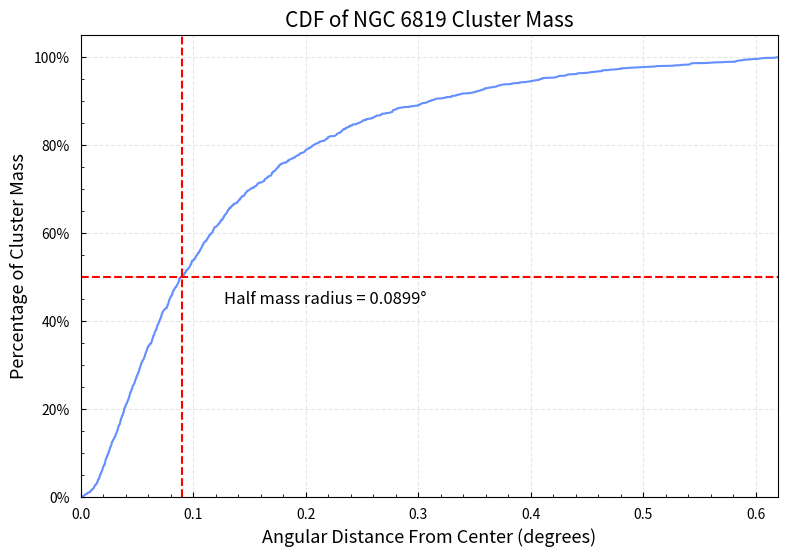

In [257]:
# Create separate total mass columns for binary and single stars
binaryPhot_copy['total_mass'] = binaryPhot_copy['m1Median'] + binaryPhot_copy['m2Median']
singlePhot_copy['total_mass'] = singlePhot_copy['m1Median']

# Concatenate the dataframes
concatenatedGaiaData = pd.concat([binaryPhot_copy, singlePhot_copy])

#Sort the dataframe by distance
concatenatedGaiaData = concatenatedGaiaData.sort_values(by='distance')

# Compute the cumulative sum of the total_mass column
concatenatedGaiaData['cumulative_mass'] = concatenatedGaiaData['total_mass'].cumsum()

# Compute the total mass
total_mass = concatenatedGaiaData['total_mass'].sum()

# Compute the cumulative percentage of the total mass
concatenatedGaiaData['cumulative_percentage'] = concatenatedGaiaData['cumulative_mass'] / total_mass * 100

# Find the radius at which half of the total mass is reached
half_mass_radius = concatenatedGaiaData.loc[concatenatedGaiaData['cumulative_percentage'] >= 50, 'distance'].iloc[0]

# Plot the cumulative percentage as a function of radius
f,ax = plt.subplots(figsize=(9,6), facecolor='w')
plt.plot(concatenatedGaiaData['distance'], concatenatedGaiaData['cumulative_percentage'], color='#648fff')
plt.axvline(x=half_mass_radius, color='red', linestyle='--')
plt.axhline(y=50, color='red', linestyle='--')
plt.annotate(text=f'Half mass radius = {half_mass_radius:.4f}\u00b0', color='black', xy=(.127,44), xytext=(.127,44), size=12)
plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Cluster Mass", fontsize=13)
plt.title("CDF of NGC 6819 Cluster Mass", fontsize=15)
plt.grid(linestyle='--', alpha=0.3)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.tick_params(axis='both', pad=8)
ax.set_xlim(0,.62)
ax.set_ylim(0,None)
print(total_mass, total_mass/2, half_mass_radius)
plt.show()


In [258]:
# Calculate half-mass radius
distance = 10 ** ((distance_mod_mean + 5 - reddening_mean) / 5)

r = half_mass_radius * 3600 #convert degrees to arcseconds
R_half_pc = r * distance / 206265  #find half mass radius in pc of cluster
R_half_m = R_half_pc * 3.086 * 10 ** 16 #convert from pc to meters

R_core = 4.96 * 3600 #not sure what the core radius is that was used
a = R_core * np.sqrt(2)

# find the sums of binaries and single stars, and add them together for total mass
binaryMass = sum(binaryPhot_copy['total_mass'])
singleMass = sum(singlePhot_copy['total_mass'])
mass_tot = binaryMass + singleMass

# convert total mass from solar masses to kilograms
M = mass_tot * 1.9891 * 10 ** 30 
# gravitational constant
G = 6.67 * 10 ** -11 
# number of members
N = len(photMems_copy)
const = 0.1

# Binney & Tremaine half mass relaxation time equation
t_rh = (((0.17 * N) / np.log(const * N)) * (math.sqrt(((R_half_m) ** 3) / (G * M)))) / 31536000

# Spitzer & Hart half mass relaxation time equation
m = np.mean(photMems_copy['m1Median']) * 1.9891 * 10 ** 30
print(m)
t_rh_spitzer = (0.06 * (M ** 0.5) * (R_half_m ** 1.5)) / (m * (G ** 0.5) * np.log10(0.4 * N)) / 31536000

#Heggie & Hut - Plummer Model half mass relaxation time equation, not sure what lambda is
t_rh_heggie = ( (0.206 * N * (a**1.5)) / (np.sqrt(G*M) * np.log(10)) ) / 31536000 #from table
t_rh_heggie2 = ( (0.138 * (N**0.5) * (R_half_m**1.5)) / (np.sqrt(G*m) * np.log(10)) ) / 31536000 #from pg 147

# Calculate the mass segregation time for the most massive star
# Calculate max m and avg m
avg_m = (mass_tot / N)* 1.9891 * 10 ** 30
m_max = max(photMems_copy['m1Median']) * 1.9891 * 10 ** 30
t_seg = (avg_m / m_max) * t_rh
cluster_age = 10**np.mean(age_all)

# print results with labels and units
print(f"Half-mass radius: {R_half_pc:.2f} pc")
print(f'Total mass: {mass_tot:.2e} M☉\n')
print(f"Half-mass relaxation time (Binney & Tremaine): {t_rh:.2e} years")
print(f"Half-mass relaxation time (Spitzer & Hart): {t_rh_spitzer:.2e} years")
print(f"Half-mass relaxation time (Heggie & Hut - Plummer): {t_rh_heggie2:.2e} years")
print(f"Mass segregation time for the most massive star (Binney & Tremaine): {t_seg:.2e} years\n")
print(f'Dynamical Relaxations (Binney & Tremaine): {cluster_age/t_rh}')
print(f'Dynamical Relaxations (Spitzer & Hart): {cluster_age/t_rh_spitzer}')
print(f'Dynamical Relaxations (Heggie & Hut - Plummer): {cluster_age/t_rh_heggie2}')

2.1657934278567467e+30
Half-mass radius: 3.80 pc
Total mass: 1.87e+03 M☉

Half-mass relaxation time (Binney & Tremaine): 1.30e+08 years
Half-mass relaxation time (Spitzer & Hart): 9.49e+07 years
Half-mass relaxation time (Heggie & Hut - Plummer): 2.45e+08 years
Mass segregation time for the most massive star (Binney & Tremaine): 1.02e+08 years

Dynamical Relaxations (Binney & Tremaine): 18.696212319905015
Dynamical Relaxations (Spitzer & Hart): 25.534859634299405
Dynamical Relaxations (Heggie & Hut - Plummer): 9.872125096197905


In [259]:
#Calculate t_seg for each star with Binney & Tremaine model, and store it in phot dataframe for later
avg_m = (mass_tot / N) * 1.9891 * 10 ** 30
m_star = photMems_copy['m1Median'] * 1.9891 * 10 ** 30
photMems_copy['t_seg'] = (avg_m / m_star) * t_rh
binaryPhot_copy['t_seg'] = (avg_m / m_star) *t_rh
singlePhot_copy['t_seg'] = (avg_m / m_star) *t_rh

# Diagnostic Plots

twoside p-value: 0.002875266977487858 
twoside p-value < 0.3 degrees: 0.0005003449336469265


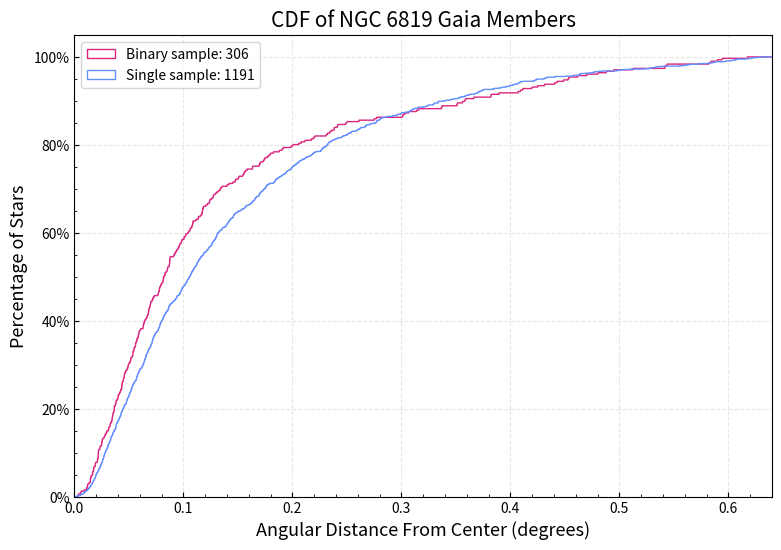

In [260]:
#full sample CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w')

single = singlePhot_copy['distance']
binary = binaryPhot_copy['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

ax.hist(binary, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 5000,color='#dc267f', label=f'Binary sample: {binarySample}')
ax.hist(single, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 5000, color='#648fff', label=f'Single sample: {singleSample}')

mask = 0.3
singlemask = singlePhot_copy['distance'][singlePhot_copy['distance'] < mask]
binarymask = binaryPhot_copy['distance'][binaryPhot_copy['distance'] < mask]

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, twoside_pvaluemask = ks_2samp(singlemask,binarymask)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')
print("twoside p-value:", twoside_pvalue, f'\ntwoside p-value < {mask} degrees:', twoside_pvaluemask)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.legend(loc='upper left')
plt.grid(linestyle='--', alpha=0.3)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.64)
plt.show()

[0.         0.11666667 0.23333333 0.35       0.46666667 0.58333333
 0.7       ] [0.         0.11666667 0.23333333 0.35       0.46666667 0.58333333
 0.7       ]


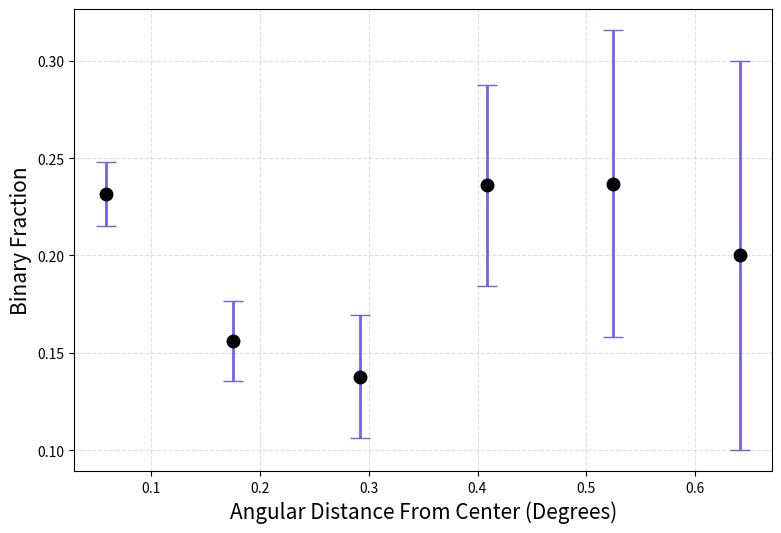

In [261]:
#NEW CODE
Nbins= np.linspace(0, .7, 7)
counts, bins3, bars =plt.hist(binaryPhot_copy['distance'], Nbins,linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=15)
plt.ylabel('N (binaries)',fontsize=15)

counts2, bins4, bars2 = plt.hist(photMems_copy['distance'], Nbins, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=15)
plt.ylabel('N',fontsize=15)

errors_y = np.sqrt(counts)/counts2

print(bins3,bins4)
primarybins2 = bins3[:-1] + (bins3[1]-bins4[0])/2

plt.close()

fig = plt.figure(figsize=(9,6), facecolor='w') # try exp bins
plt.xlabel('Angular Distance From Center (Degrees)',fontsize=15)
plt.ylabel('Binary Fraction',fontsize=15)
plt.errorbar(primarybins2, counts/counts2, xerr=None, yerr=errors_y, fmt='o',capsize=7, color='black', ecolor='#785ef0',markersize=9,linewidth=2)
plt.grid(linestyle='--', alpha=0.4)
#plt.savefig('M35plot1.pdf',dpi=300, bbox_inches="tight")

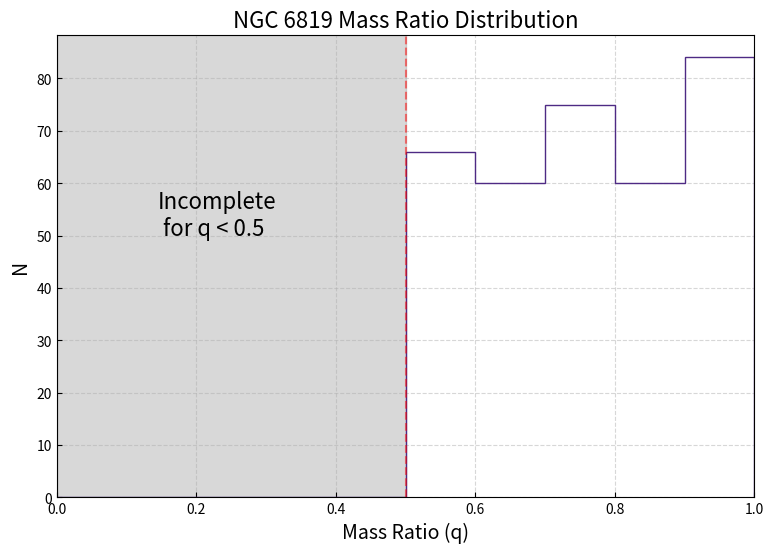

In [262]:
f, ax = plt.subplots(figsize=(9,6), facecolor='w')
photBinary = phot.loc[phot['binary']]
_ = ax.hist(photBinary['qMedian'], histtype='step', color="#4e2a84" ,bins=10, range=[0,1])
ax.set_xlabel("Mass Ratio (q)", fontsize=14)
ax.set_ylabel("N", fontsize=14)
ax.annotate(text='Incomplete\n for q < 0.5', xy=(.145,50), xytext=(.145,50), fontsize=16)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax.axvspan(0,0.5, color='gray', alpha=0.3)
ax.set_title("NGC 6819 Mass Ratio Distribution", fontsize=16)
plt.grid(linestyle='--', alpha=0.5)
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,1)
plt.savefig("massratio.png", dpi=300)

# Other Plots 

twoside p-value: 0.002875266977487858 
twoside p-value < 0.4 degrees: 0.0005612820963407988


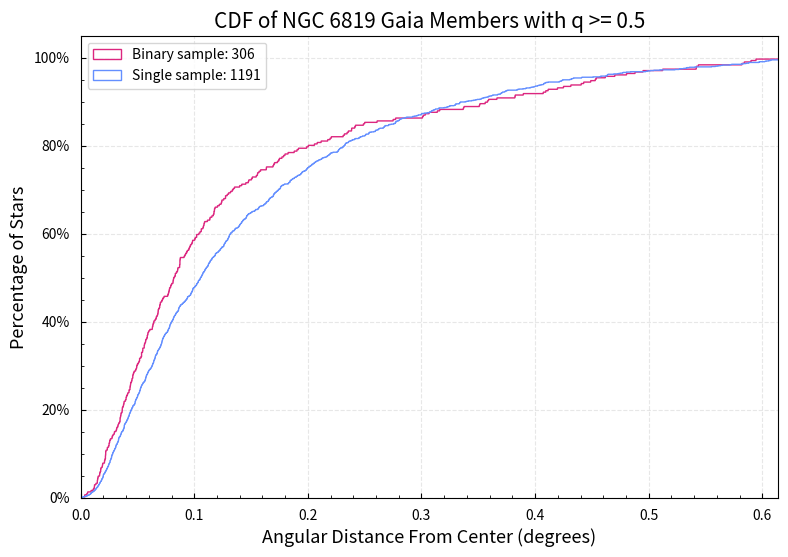

In [263]:
#massratio CDF
# Select rows where qMean is greater than or equal to 0.5
qcutSingle = singlePhot_copy[singlePhot_copy['qMedian'] >= 0.00000000001]
qcutBinary = binaryPhot_copy[binaryPhot_copy['qMedian'] >= 0.5]

f,ax = plt.subplots(figsize=(9,6), facecolor='w')

single = qcutSingle['distance']
binary = qcutBinary['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

binaryhist = ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 5000,color='#dc267f', label= f'Binary sample: {binarySample}')
singlehist = ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 5000, color='#648fff', label=f'Single sample: {singleSample}')

mask = 0.4
singlemask = qcutSingle['distance'][qcutSingle['distance'] < mask]
binarymask = qcutBinary['distance'][qcutBinary['distance'] < mask]

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, twoside_pvaluemask = ks_2samp(singlemask,binarymask)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')
print("twoside p-value:", twoside_pvalue, f'\ntwoside p-value < {mask} degrees:', twoside_pvaluemask)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members with q >= 0.5", fontsize=15)
plt.grid(linestyle='--', alpha=0.3)
plt.legend(loc='upper left')
# plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\nBinary sample: {binarySample}\nSingle sample: {singleSample}',fontsize = 10, 
#          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# custom_lines = [Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
#                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'),]

# twoside= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {twoside_pvalue:.5f}', color=None, linestyle=None)
# less= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {less_pvalue:.5f}', color=None, linestyle=None)
#ax.legend(loc=2, fontsize=8)
#leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc=2, fontsize=9)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)

# plt.annotate(text="Binary stars", color='g', xy=(.09,.81), xytext=(.09,.81), size=12)
# plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.tick_params(axis='both', pad=8)
ax.set_xlim(0,.614)
plt.show()

12 19


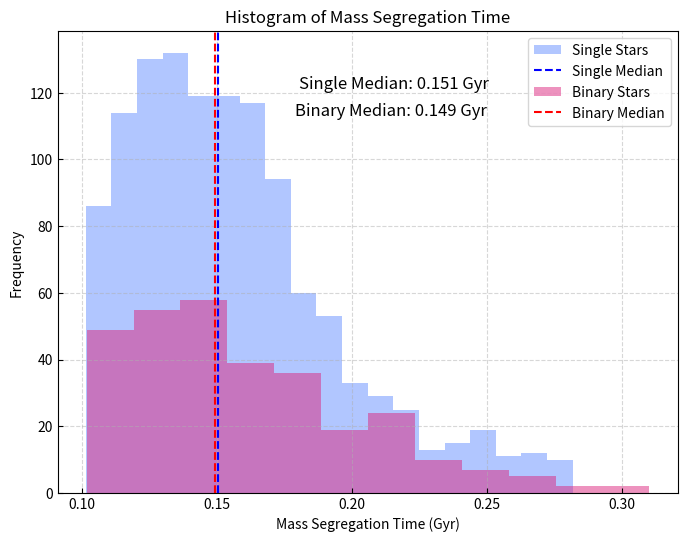

In [264]:
#t_seg hist
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(8, 6), facecolor='w')
bins = 20

# Calculate the interquartile range (IQR)
iqr_single = np.percentile(singlePhot_copy['t_seg'], 75) - np.percentile(singlePhot_copy['t_seg'], 25)
iqr_binary = np.percentile(binaryPhot_copy['t_seg'], 75) - np.percentile(binaryPhot_copy['t_seg'], 25)

# Calculate the bin width using the Freedman-Diaconis rule
bin_width_single = 2 * iqr_single * (len(singlePhot_copy['t_seg']) ** (-1/3))
bin_width_binary = 2 * iqr_binary * (len(binaryPhot_copy['t_seg']) ** (-1/3))

# Calculate the number of bins using the bin width
bins_single = int((np.max(singlePhot_copy['t_seg']) - np.min(singlePhot_copy['t_seg'])) / bin_width_single)
bins_binary = int((np.max(binaryPhot_copy['t_seg']) - np.min(binaryPhot_copy['t_seg'])) / bin_width_binary)
print(bins_binary,bins_single)

plt.grid(linestyle='--', alpha=0.5)
ax.tick_params(which='both', direction="in")

single_median = np.median(singlePhot_copy['t_seg'])
binary_median = np.median(binaryPhot_copy['t_seg'])

single_counts, single_bins, _ = ax.hist(singlePhot_copy['t_seg'], bins=bins_single, alpha=0.5, color='#648fff', label='Single Stars')
ax.axvline(np.median(singlePhot_copy['t_seg']), ls='--', c='b', label='Single Median')
binary_counts, binary_bins, _ = ax.hist(binaryPhot_copy['t_seg'], bins=bins_binary, alpha=0.5, color='#dc267f', label='Binary Stars')
ax.axvline(np.median(binaryPhot_copy['t_seg']), ls='--', c='r', label='Binary Median')

ax.annotate(text=f'Single Median: {single_median/1e9:.3f} Gyr', 
             xy=(single_median+.65e8, 120), xytext=(single_median+.65e8, 120),
             ha='center', va='bottom', size=12)
ax.annotate(text=f'Binary Median: {binary_median/1e9:.3f} Gyr', 
             xy=(binary_median+.65e8,112), xytext=(binary_median+.65e8, 112),
             ha='center', va='bottom', size=12)

ax.set_xlabel('Mass Segregation Time (Gyr)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Mass Segregation Time')
ax.legend()

# Define the conversion function
def year_to_gigayear(x, pos):
    return f'{x * 1e-9:.2f}'

# Create a FuncFormatter object using the conversion function
formatter = ticker.FuncFormatter(year_to_gigayear)

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(formatter)


In [265]:
number_bins = 4

# Sort the data in ascending order
sorted_data = np.sort(binaryPhot_copy['t_seg'])

# Calculate the total number of data points
total_points = len(sorted_data)

# Calculate the sample size for each bin
sample_size = total_points // number_bins

# Initialize an empty list to store the bin endpoints
binary_endpoints = []

# Iterate over the number of bins
for i in range(number_bins):
    # Calculate the indices for the start and end of the current bin
    start_index = i * sample_size
    end_index = start_index + sample_size - 1
    
    # Append the bin endpoints to the list
    binary_endpoints.append(sorted_data[end_index])

#print(bin_endpoints)

Min: 0.102 Gyr 
Max: 0.310 Gyr
0.15201610933264875
0.4057395646071462
0.010084194551935027
0.001793460552415978


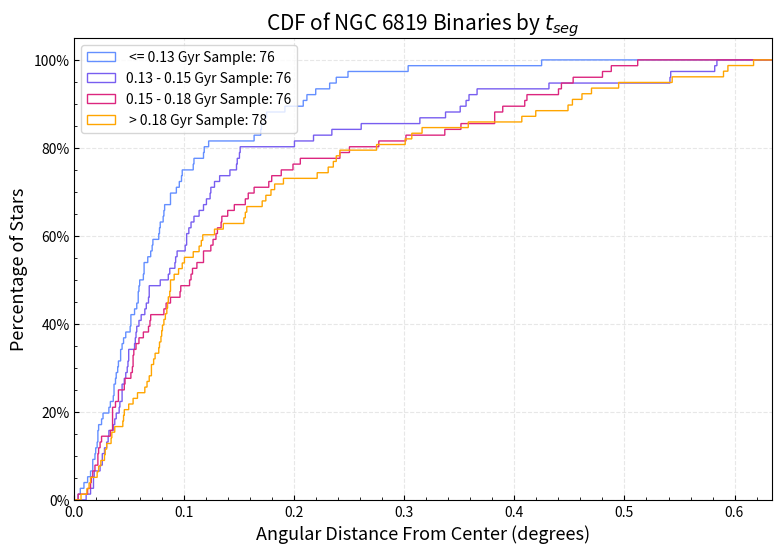

In [266]:
#t_seg bins for BINARY stars
f,ax = plt.subplots(figsize=(9,6), facecolor='w')

min_tseg = np.min(binaryPhot_copy['t_seg'])
max_tseg = np.max(binaryPhot_copy['t_seg'])
print(f'Min: {min_tseg/1e9:.3f} Gyr', f'\nMax: {max_tseg/1e9:.3f} Gyr')

binaryfilter1 = binaryPhot_copy.loc[(binaryPhot_copy['t_seg']  >= min_tseg) & (binaryPhot_copy['t_seg']  <= binary_endpoints[0])]
binaryfilter2 = binaryPhot_copy.loc[(binaryPhot_copy['t_seg']  > binary_endpoints[0]) & (binaryPhot_copy['t_seg']  <=  binary_endpoints[1])]
binaryfilter3 = binaryPhot_copy.loc[(binaryPhot_copy['t_seg']  > binary_endpoints[1] ) & (binaryPhot_copy['t_seg']  <=  binary_endpoints[2])]
binaryfilter4 = binaryPhot_copy.loc[(binaryPhot_copy['t_seg']  > binary_endpoints[2] ) & (binaryPhot_copy['t_seg']  <= max_tseg)]

#print(binaryfilter1)
#binary = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <  1.3)]

binarybin1 = binaryfilter1['distance']
binarybin2 = binaryfilter2['distance']
binarybin3 = binaryfilter3['distance']
binarybin4 = binaryfilter4['distance']
allbinaries = binaryPhot_copy['distance']

binarybin1Sample = binarybin1.shape[0]
binarybin2Sample = binarybin2.shape[0]
binarybin3Sample = binarybin3.shape[0]
binarybin4Sample = binarybin4.shape[0]
allSample = binaryPhot_copy.shape[0]
# print(binary)

ax.hist(binarybin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', label=f' <= {binary_endpoints[0]/1e9:.2f} Gyr Sample: {binarybin1Sample}')
ax.hist(binarybin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#785ef0', label=f'{binary_endpoints[0]/1e9:.2f} - {binary_endpoints[1]/1e9:.2f} Gyr Sample: {binarybin2Sample}')
ax.hist(binarybin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', label=f'{binary_endpoints[1]/1e9:.2f} - {binary_endpoints[2]/1e9:.2f} Gyr Sample: {binarybin3Sample}')
ax.hist(binarybin4, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='orange', label=f' > {binary_endpoints[2]/1e9:.2f} Gyr Sample: {binarybin4Sample}')
#ax.hist(allbinaries, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#FFB000', label=f'All Samples: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(binarybin1,binarybin2)
ks_result, less_pvalue1 = ks_2samp(binarybin1,binarybin2,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(binarybin2,binarybin3)
ks_result, less_pvalue2= ks_2samp(binarybin2,binarybin3,alternative='less')
print(twoside_pvalue2)

ks_result, twoside_pvalue3= ks_2samp(binarybin1,binarybin3)
ks_result, less_pvalue3 = ks_2samp(binarybin1,binarybin3,alternative='less')
print(twoside_pvalue3)

ks_result, twoside_pvalue4= ks_2samp(binarybin1,binarybin4)
ks_result, less_pvalue4 = ks_2samp(binarybin1,binarybin4,alternative='less')
print(twoside_pvalue4)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Binaries by $t_{seg}$", fontsize=15)
plt.legend(loc='upper left')
plt.grid(linestyle='--', alpha=0.3)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.634)
plt.show()

In [267]:
number_bins = 4

# Sort the data in ascending order
sorted_data = np.sort(singlePhot_copy['t_seg'])

# Calculate the total number of data points
total_points = len(sorted_data)

# Calculate the sample size for each bin
sample_size = total_points // number_bins

# Initialize an empty list to store the bin endpoints
single_endpoints = []

# Iterate over the number of bins
for i in range(number_bins):
    # Calculate the indices for the start and end of the current bin
    start_index = i * sample_size
    end_index = start_index + sample_size - 1
    
    # Append the bin endpoints to the list
    single_endpoints.append(sorted_data[end_index])

#print(bin_endpoints)

Min: 0.102 Gyr 
Max: 0.282 Gyr
0.0011554613983057115
0.14278770314242487
1.8821074902709894e-06
8.859395923119137e-15


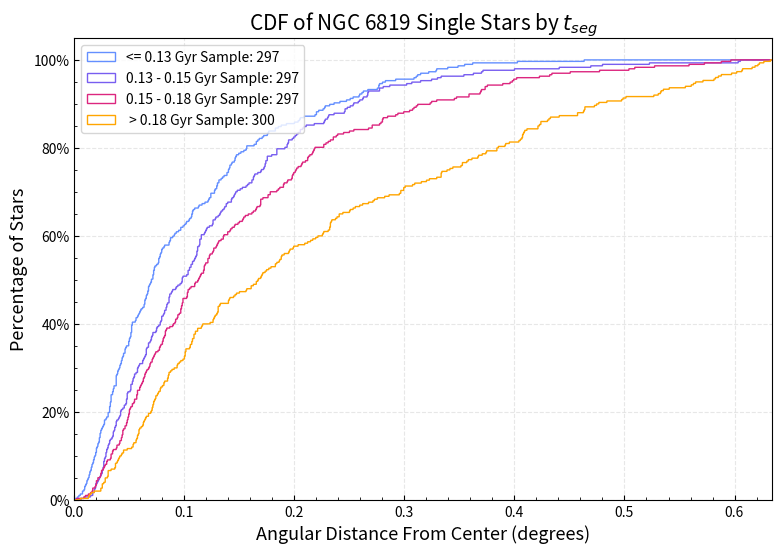

In [268]:
#t_seg bins for SINGLE stars
f,ax = plt.subplots(figsize=(9,6), facecolor='w')

min_tseg = np.min(singlePhot_copy['t_seg'])
max_tseg = np.max(singlePhot_copy['t_seg'])
print(f'Min: {min_tseg/1e9:.3f} Gyr', f'\nMax: {max_tseg/1e9:.3f} Gyr')

singlefilter1 = singlePhot_copy.loc[(singlePhot_copy['t_seg']  >= min_tseg) & (singlePhot_copy['t_seg']  <= single_endpoints[0])]
singlefilter2 = singlePhot_copy.loc[(singlePhot_copy['t_seg']  > single_endpoints[0]) & (singlePhot_copy['t_seg']  <=  single_endpoints[1])]
singlefilter3 = singlePhot_copy.loc[(singlePhot_copy['t_seg']  > single_endpoints[1] ) & (singlePhot_copy['t_seg']  <=  single_endpoints[2])]
singlefilter4 = singlePhot_copy.loc[(singlePhot_copy['t_seg']  > single_endpoints[2] ) & (singlePhot_copy['t_seg']  <= max_tseg)]

#print(binaryfilter1)
#binary = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <  1.3)]

singlebin1 = singlefilter1['distance']
singlebin2 = singlefilter2['distance']
singlebin3 = singlefilter3['distance']
singlebin4 = singlefilter4['distance']
#allsingle = singlePhot_copy['distance']

singlebin1Sample = singlebin1.shape[0]
singlebin2Sample = singlebin2.shape[0]
singlebin3Sample = singlebin3.shape[0]
singlebin4Sample = singlebin4.shape[0]
#allSample = singlePhot_copy.shape[0]
# print(binary)

ax.hist(singlebin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', label=f'<= {single_endpoints[0]/1e9:.2f} Gyr Sample: {singlebin1Sample}')
ax.hist(singlebin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#785ef0', label=f'{single_endpoints[0]/1e9:.2f} - {single_endpoints[1]/1e9:.2f} Gyr Sample: {singlebin2Sample}')
ax.hist(singlebin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', label=f'{single_endpoints[1]/1e9:.2f} - {single_endpoints[2]/1e9:.2f} Gyr Sample: {singlebin3Sample}')
ax.hist(singlebin4, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='orange', label=f' > {single_endpoints[2]/1e9:.2f} Gyr Sample: {singlebin4Sample}')
#ax.hist(allsingle, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#FFB000', label=f'All Samples: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(singlebin1,singlebin2)
ks_result, less_pvalue1 = ks_2samp(singlebin1,singlebin2,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(singlebin2,singlebin3)
ks_result, less_pvalue2= ks_2samp(singlebin2,singlebin3,alternative='less')
print(twoside_pvalue2)

ks_result, twoside_pvalue3= ks_2samp(singlebin1,singlebin3)
ks_result, less_pvalue3 = ks_2samp(singlebin1,singlebin3,alternative='less')
print(twoside_pvalue3)

ks_result, twoside_pvalue4= ks_2samp(singlebin1,singlebin4)
ks_result, less_pvalue4 = ks_2samp(singlebin1,singlebin4,alternative='less')
print(twoside_pvalue4)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Single Stars by $t_{seg}$", fontsize=15)
plt.legend(loc='upper left')
plt.grid(linestyle='--', alpha=0.3)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.634)
plt.show()

Single Min: 0.102 Gyr 
Single Max: 0.282 Gyr
Binary Min: 0.102 Gyr 
Binary Max: 0.310 Gyr
0.0031476251845072916
0.19408479729080141


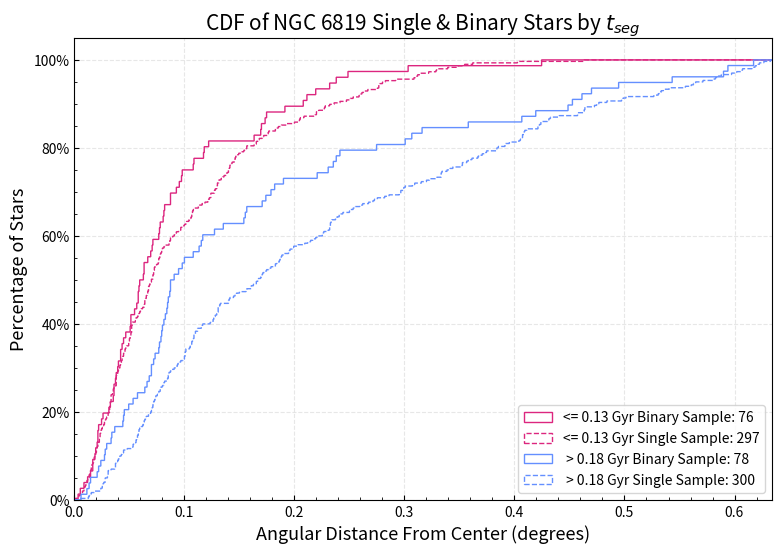

In [306]:
#t_seg bins for SINGLE stars
f,ax = plt.subplots(figsize=(9,6), facecolor='w')

singlemin_tseg = np.min(singlePhot_copy['t_seg'])
singlemax_tseg = np.max(singlePhot_copy['t_seg'])
print(f'Single Min: {singlemin_tseg/1e9:.3f} Gyr', f'\nSingle Max: {singlemax_tseg/1e9:.3f} Gyr')
binarymin_tseg = np.min(binaryPhot_copy['t_seg'])
binarymax_tseg = np.max(binaryPhot_copy['t_seg'])
print(f'Binary Min: {binarymin_tseg/1e9:.3f} Gyr', f'\nBinary Max: {binarymax_tseg/1e9:.3f} Gyr')

# ax.hist(bin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', label=f'<= {bin_endpoints[0]/1e9:.2f} Gyr Sample: {bin1Sample}')
# ax.hist(bin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#785ef0', label=f'{bin_endpoints[0]/1e9:.2f} - {bin_endpoints[1]/1e9:.2f} Gyr Sample: {bin2Sample}')
# ax.hist(bin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', label=f'{bin_endpoints[1]/1e9:.2f} - {bin_endpoints[2]/1e9:.2f} Gyr Sample: {bin3Sample}')

ax.hist(binarybin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', label=f'<= {binary_endpoints[0]/1e9:.2f} Gyr Binary Sample: {binarybin1Sample}')
ax.hist(singlebin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#dc267f', ls='--', label=f'<= {single_endpoints[0]/1e9:.2f} Gyr Single Sample: {singlebin1Sample}')

ax.hist(binarybin4, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', label=f' > {binary_endpoints[2]/1e9:.2f} Gyr Binary Sample: {binarybin4Sample}')
ax.hist(singlebin4, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#648fff', ls='--', label=f' > {single_endpoints[2]/1e9:.2f} Gyr Single Sample: {singlebin4Sample}')
#ax.hist(allsingle, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#FFB000', label=f'All Samples: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(binarybin4,singlebin4)
ks_result, less_pvalue1 = ks_2samp(binarybin4,singlebin4,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(binarybin1,singlebin1)
ks_result, less_pvalue2 = ks_2samp(binarybin1,singlebin1,alternative='less')
print(twoside_pvalue2)
plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Single & Binary Stars by $t_{seg}$", fontsize=15)
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.3)

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.634)
plt.show()

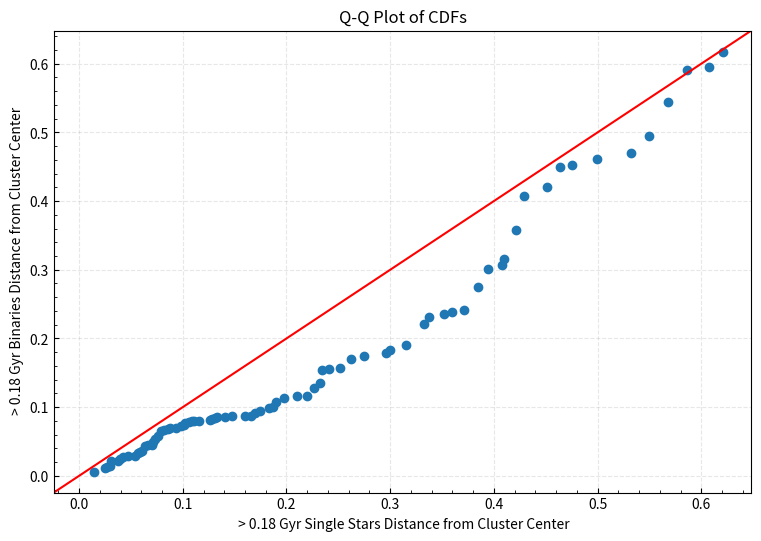

In [303]:
import statsmodels.api as sm

f, ax = plt.subplots(figsize=(9, 6), facecolor='w')
plt.grid(linestyle='--', alpha=0.3)
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")

qqplot = sm.qqplot_2samples(singlebin4, binarybin4, line='45', ax=ax)
#qqplot2 = sm.qqplot_2samples(singlebin1, binarybin1, line='45', ax=ax)
ax.set_xlabel(f' > {single_endpoints[2]/1e9:.2f} Gyr Single Stars Distance from Cluster Center')
ax.set_ylabel(f' > {binary_endpoints[2]/1e9:.2f} Gyr Binaries Distance from Cluster Center')
ax.set_title('Q-Q Plot of CDFs')
ax.grid(ls='--', alpha=0.3)

In [271]:
# Nbins = np.linspace(0, 0.7, 6)

# counts, bins3, bars = plt.hist(binaryPhot_copy['distance'], Nbins, linewidth=2, color='purple', rwidth=0.97)
# counts2, bins4, bars2 = plt.hist(photMems_copy['distance'], Nbins, range=[0, 1], linewidth=2, color='purple', rwidth=0.97)
# plt.close()
# errors_y = np.sqrt(counts) / counts2
# primarybins2 = bins3[:-1] + (bins3[1] - bins4[0]) / 2

# # Create a figure and a 1 row, 3 wide subplot
# fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# # Figure 1
# axs[0].hist(binaryPhot_copy['distance'], bins=Nbins, range=[0,1], linewidth=2, color='purple', rwidth=0.97)
# axs[0].set_xlabel('Angular Distance From Center (Degrees)', fontsize=20)
# axs[0].set_ylabel('N (Binaries)', fontsize=20)

# # Figure 2
# axs[1].hist(photMems_copy['distance'], bins=Nbins, range=[0, 1], linewidth=2, color='purple', rwidth=0.97)
# axs[1].set_xlabel('Angular Distance From Center (Degrees)', fontsize=20)
# axs[1].set_ylabel('N', fontsize=20)

# # Figure 3
# axs[2].errorbar(primarybins2, counts / counts2, xerr=None, yerr=errors_y, fmt='o', capsize=5, color='black', ecolor='b', markersize=10, linewidth=2)
# axs[2].set_xlabel('Angular Distance From Center (Degrees)', fontsize=20)
# axs[2].set_ylabel('Binary Fraction', fontsize=20)
# axs[2].grid(linestyle='--', alpha=0.4)

# # Adjust subplot spacing
# plt.tight_layout()

# # Show the plot
# plt.show()


## Misc

(23.0, 12.0)

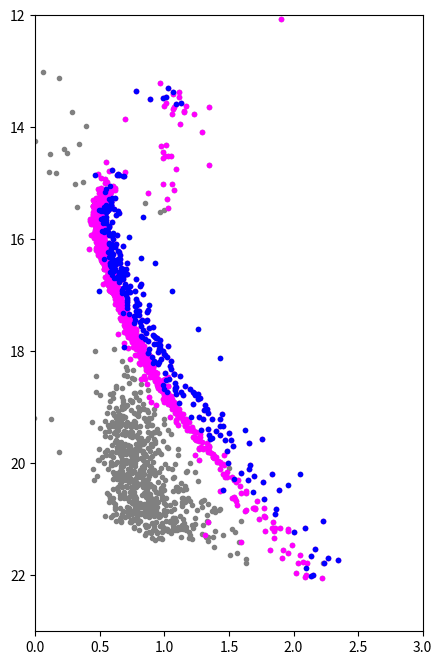

In [272]:
f, ax = plt.subplots(figsize=(5,8))
photMems = phot.loc[phot['member']]
photBinary = phot.loc[phot['binary']]
ax.plot(phot['g_ps'] - phot['i_ps'], phot['g_ps'],'.', color='gray')
ax.plot(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],'.', color='magenta')
ax.plot(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'],'.', color='blue')
ax.set_xlim(0, 3)
ax.set_ylim(23, 12)

In [273]:
# r = photBinary['qMedian']
# f, ax = plt.subplots(figsize=(8,15))

# ax.set_xlabel('G_BP - G_RP',fontsize=18)
# ax.set_ylabel('G',fontsize=18)
# #plot phot and cluster members
# #plt.scatter(originalGaia['G_BP'] - originalGaia['G_RP'], originalGaia['G'],s=15, color='lightgray',label='Sample From Gaia')
# plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='#707070',label='Gaia Cluster Members')
# plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=20, color='#000000',label='Gaia+BASE9 Cluster Members')
# #plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')
# ax.set_xlim(0, 3)
# ax.set_ylim(21,10)


# #plot colorbar
# plt.scatter(photBinary['G_BP'] - photBinary['G_RP'], photBinary['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75,label='Identified Binaries')

# plt.colorbar(label="Mass Ratio", orientation="horizontal",pad=0,location='top')


# #overplot isochrone
# photfile = ph
# cmdfile = r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
# mag       = 'G'
# color     = 'G_BP-G_RP'.split('-')
# header   = np.loadtxt(cmdfile,max_rows=1,dtype=str)
# yplot     = np.where(header == mag)[0][0]
# color1    = np.where(header == color[0])[0][0]
# color2    = np.where(header == color[1])[0][0]
# data = np.loadtxt(cmdfile,skiprows=1)
# ymag    = data[:,yplot]
# color   = data[:,color1] - data[:,color2]
# plt.plot(color, ymag, color='red',linewidth=1,label='Isochrone')
# plt.legend(loc="upper right",edgecolor='black')
# #plt.show()
# plt.savefig('MegaCMD1.png',dpi=300, bbox_inches="tight")
    


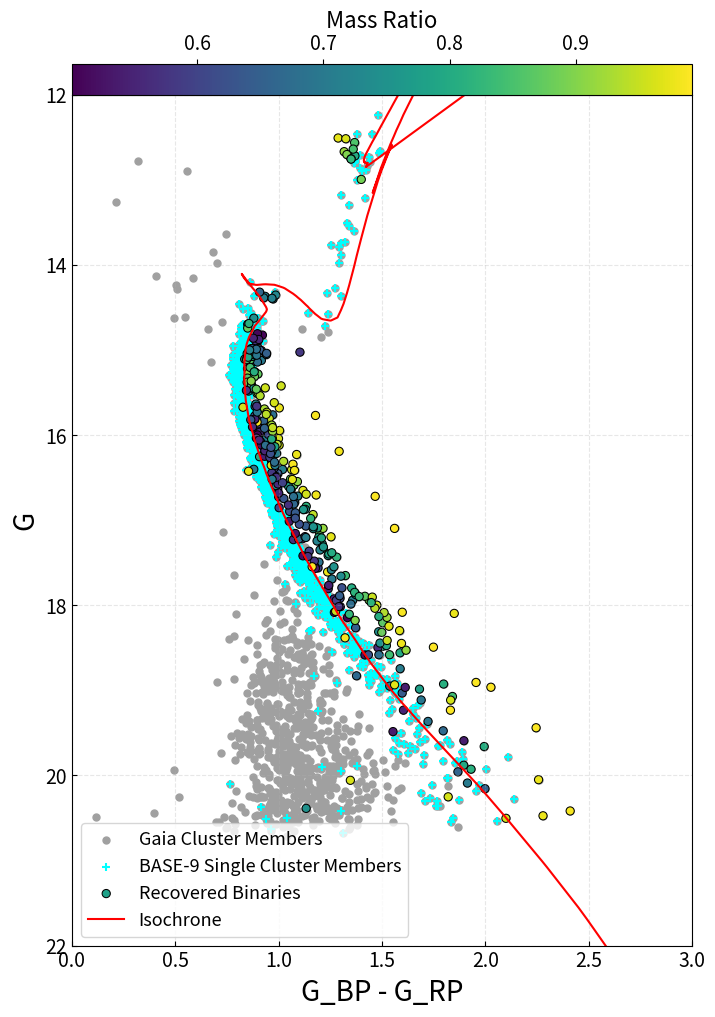

In [274]:
r = photBinary['qMedian']
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
plt.grid(linestyle='--', alpha=0.3)
#plot phot and cluster members
#plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')


ax.set_xlim(0, 3)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(photBinary['G_BP'] - photBinary['G_RP'], photBinary['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, label="Recovered Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
cbar.set_label("Mass Ratio", fontsize=16)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
mag     = "G"
color     = "G_BP-G_RP".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
plt.savefig('cmdWithMassRatio.png', dpi=300)

plt.show()

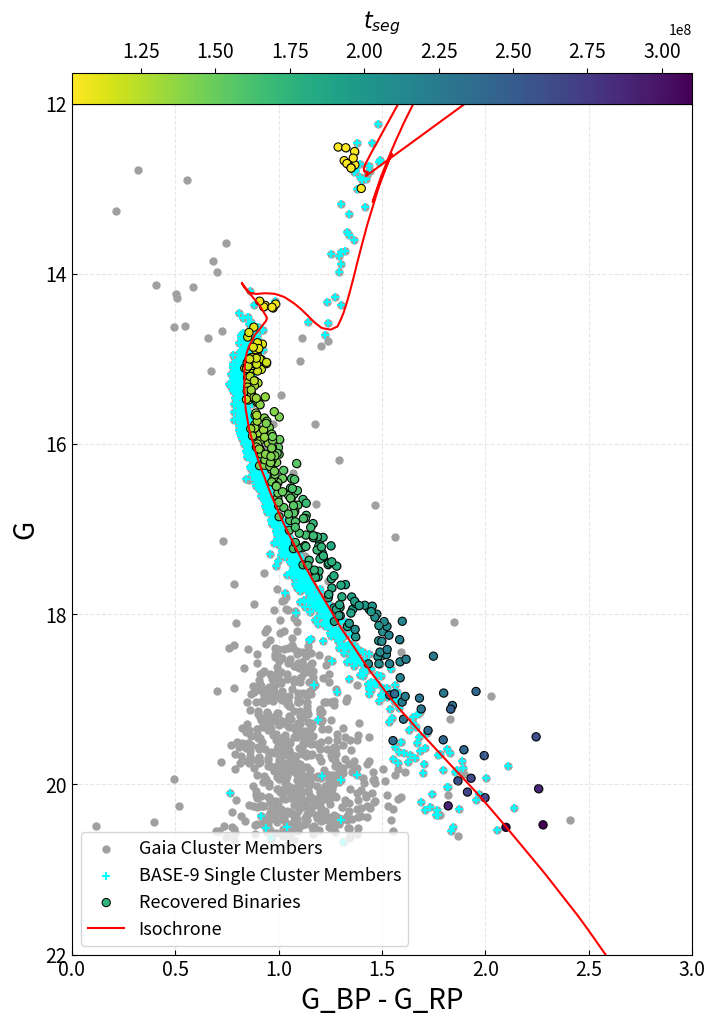

In [275]:
r = binaryPhot_copy['t_seg']
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
plt.grid(linestyle='--', alpha=0.3)
#plot phot and cluster members
#plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=25, color='#A0A0A0', label="Gaia Cluster Members") # check tseg was calculated
plt.scatter(photMems_copy['G_BP'] - photMems_copy['G_RP'], photMems_copy['G'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')

ax.set_xlim(0, 3)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(binaryPhot_copy['G_BP'] - binaryPhot_copy['G_RP'], binaryPhot_copy['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis").reversed(),edgecolors= "black",linewidth=0.75, label="Recovered Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
cbar.set_label("$t_{seg}$", fontsize=16, labelpad=10)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/NGC6819_FINAL/NGC_6819_final.ms"
mag     = "G"
color     = "G_BP-G_RP".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
plt.savefig('cmdWithtSegregation.png', dpi=300)

plt.show()